In [22]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
import numpy as np
colors = cm.magma(np.linspace(0, 0.8, 15))

pd.set_option('display.max_columns', None)
sys.path.append(os.path.abspath("../.."))  # Add parent folder to path

In [23]:
rotas = pd.read_parquet(r"../../dados/rotas_historico_categorizado.parquet")
viagens = pd.read_parquet("../../dados/trips_historico.parquet")
# estacoes_metro_e_trem = pd.read_parquet("../../dados/estacoes_metro_e_trem.parquet")
paradas=pd.read_parquet("../../dados/stops_historico_categorizado.parquet")
passageiros=pd.read_parquet("../../dados/passageiros_unificado.parquet")

df_zonas=pd.read_excel("../../dados/tabela_regioes_sp.xlsx")


# rotas['data_referencia']=pd.to_datetime(rotas['data_referencia'],format="%Y%m").dt.to_period('M')
viagens['data_referencia']=pd.to_datetime(viagens['data_referencia'],format="%Y%m").dt.to_period('M')
paradas['data_referencia']=pd.to_datetime(paradas['data_referencia'],format="%Y%m").dt.to_period('M')
passageiros['data']=passageiros['data'].dt.to_period('M')

passageiros=passageiros.groupby(["data",'route_id']).sum().reset_index()


# Linhas que são próximas ao metrô Vila Sônia

In [24]:
df_paradas_vila_sonia=paradas[(paradas.nome_estacao_mais_proxima=='VILA SÔNIA')]
viagens_vila_sonia=viagens.merge(df_paradas_vila_sonia,on=['stop_id', 'stop_name', 'stop_desc', 'stop_lat', 'stop_lon',
       'data_referencia',],how='inner')
rotas_oeste=viagens_vila_sonia[viagens_vila_sonia['Regiões']=='Oeste'].route_id.drop_duplicates().to_list()

# Calcula distância percorrida por cada rota

In [25]:
rotas_dist_km=pd.read_parquet("../../dados/routes_dist_km_historico.parquet")
routes_dist_km_percorridos=pd.read_parquet("../../dados/routes_dist_km_percorridos_historico.parquet")

rotas_dist=rotas_dist_km.merge(routes_dist_km_percorridos,on=['route_id','data_referencia'])

In [26]:

rotas_distkm = (
    rotas_dist
    .groupby(['route_id'])
    .agg(
        min_dist_km=('dist_km', 'min'),
        max_dist_km=('dist_km', 'max'),
        min_dist_km_percorrido=('distancia_km_percorrido', 'min'),
        max_dist_km_percorrido=('distancia_km_percorrido', 'max')
    ).reset_index())

rotas_distkm=rotas_distkm[rotas_distkm.min_dist_km!=0]
rotas_distkm['dist_km']=rotas_distkm['max_dist_km']-rotas_distkm['min_dist_km']
rotas_distkm['dist_km_percorrido']=rotas_distkm['max_dist_km_percorrido']-rotas_distkm['min_dist_km_percorrido']

rotas_distkm=rotas_distkm.sort_values("dist_km",ascending=False)

rotas_distkm=rotas_distkm[(rotas_distkm.dist_km>1)&(~rotas_distkm.route_id.str.contains("METRÔ"))].merge(rotas[['route_long_name','route_id']],on='route_id').drop_duplicates()

In [27]:
rotas_dist_km_vila_sonia=rotas_distkm[rotas_distkm.route_id.isin(rotas_oeste)&(rotas_distkm.route_long_name.str.lower().str.contains("sônia"))]
display(rotas_dist_km_vila_sonia)

,route_id,min_dist_km,max_dist_km,min_dist_km_percorrido,max_dist_km_percorrido,dist_km,dist_km_percorrido,route_long_name
6,745810,6.189507,17.096346,15.104119,39.557261,10.906839,24.453142,"Jd. Boa Vista - Est. Da Luz, Jd. Boa Vista - E..."
22,701310,5.684849,10.539948,17.388542,28.619746,4.855099,11.231204,"Pq. Arariba - Pinheiros, Pq. Arariba - Term. V..."
28,807710,6.176721,9.682711,16.127491,21.796359,3.505991,5.668868,"Jd. João Xxiii - Metrô Butantã, Jd. João Xxiii..."
29,807310,3.438301,6.733491,11.182211,17.160167,3.295190,5.977957,"Jardim Guaraú - Butantã, Jd. Guaraú - Butantã,..."
30,802310,6.945729,10.134850,15.613494,21.360394,3.189122,5.746899,"Cdhu Munck - Butantã, Cdhu Munck - Term. Morum..."
34,802610,5.014927,8.091129,17.641086,24.540180,3.076202,6.899094,"Jd. Inga - Butantã, Jd. Ingá - Butantã, Jd. In..."
38,802510,3.727406,6.657830,12.539982,17.317601,2.930424,4.777619,"Jd. Rosa Maria - Butantã, Jd. Rosa Maria - Ter..."
49,801810,3.024805,4.846033,10.493089,14.170613,1.821228,3.677524,"Vila Sônia - Butantã, Vl. Sônia - Butantã, Vl...."
69,807521,5.787436,7.136091,12.104513,15.360588,1.348655,3.256075,"Term. Campo Limpo - Term. Morumbi, Term. Campo..."


In [28]:
print(rotas_dist_km_vila_sonia.to_latex())

\begin{tabular}{llrrrrrrl}
\toprule
 & route_id & min_dist_km & max_dist_km & min_dist_km_percorrido & max_dist_km_percorrido & dist_km & dist_km_percorrido & route_long_name \\
\midrule
6 & 745810 & 6.189507 & 17.096346 & 15.104119 & 39.557261 & 10.906839 & 24.453142 & Jd. Boa Vista - Est. Da Luz, Jd. Boa Vista - Estação Da Luz, Jd. Boa Vista - Term. Vl. Sônia \\
22 & 701310 & 5.684849 & 10.539948 & 17.388542 & 28.619746 & 4.855099 & 11.231204 & Pq. Arariba - Pinheiros, Pq. Arariba - Term. Vl. Sônia \\
28 & 807710 & 6.176721 & 9.682711 & 16.127491 & 21.796359 & 3.505991 & 5.668868 & Jd. João Xxiii - Metrô Butantã, Jd. João Xxiii - Term. Morumbi, Jd. João Xxiii - Term. Vl. Sônia \\
29 & 807310 & 3.438301 & 6.733491 & 11.182211 & 17.160167 & 3.295190 & 5.977957 & Jardim Guaraú - Butantã, Jd. Guaraú - Butantã, Jd. Guaraú - Term. Morumbi, Jd. Guaraú - Term. Vl. Sônia \\
30 & 802310 & 6.945729 & 10.134850 & 15.613494 & 21.360394 & 3.189122 & 5.746899 & Cdhu Munck - Butantã, Cdhu Munck - Te

# Quantidade de passageiros nas linhas alteradas

In [29]:
rotas_filtradas=rotas_dist_km_vila_sonia.route_id.drop_duplicates().to_list()

passageiros_filtrado=passageiros[passageiros.route_id.isin(rotas_filtradas)]
passageiros_filtrado=passageiros_filtrado[passageiros_filtrado.data<="2025-03-31"]
df_pivot = passageiros_filtrado.pivot_table(index='data', columns='route_id', values='passageiros_total', aggfunc='sum')
df_pivot = df_pivot.fillna(0).sort_index()
df_pivot.index = df_pivot.index.to_timestamp()

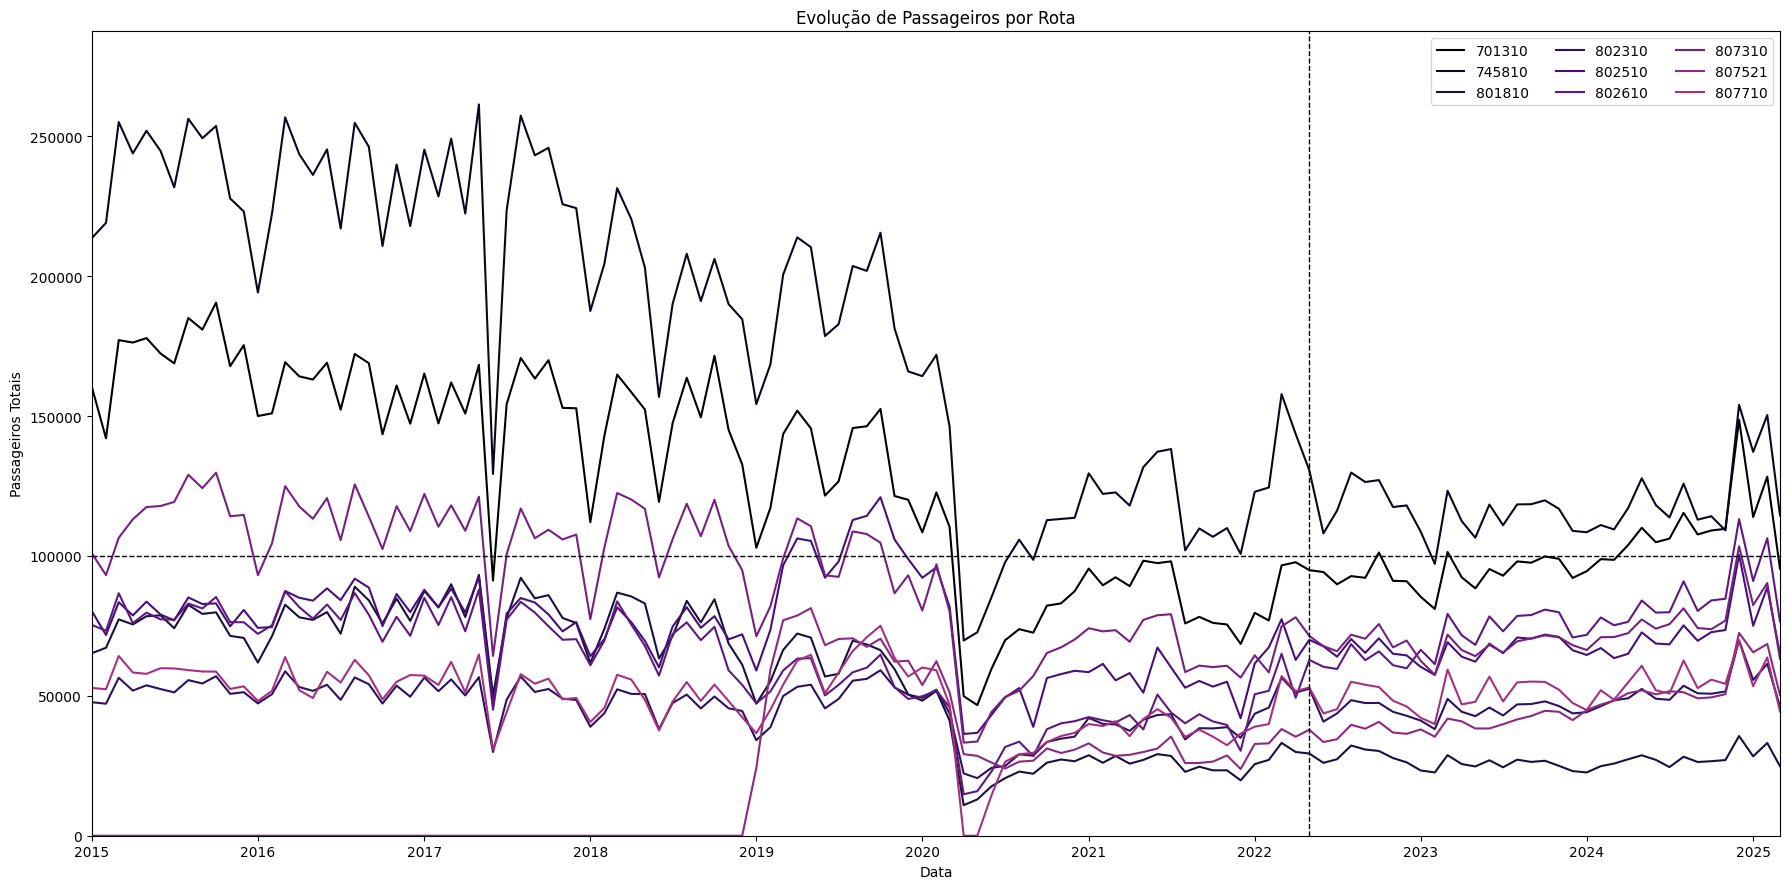

In [30]:
fig, ax = plt.subplots(figsize=(18, 9))

# Aplica as cores, repetindo se houver mais que 20 rotas
for i, route in enumerate(df_pivot.columns):
    ax.plot(
        df_pivot.index.to_pydatetime(),
        df_pivot[route],
        label=route,
        color=colors[i % len(colors)]
    )

ax.set_xlim(df_pivot.index.min().to_pydatetime(), df_pivot.index.max().to_pydatetime())
ax.set_ylim(0, df_pivot.values.max() * 1.1)
ax.set_title('Evolução de Passageiros por Rota')
ax.set_xlabel('Data')
ax.set_ylabel('Passageiros Totais')

# Linhas adicionais para análise
ax.axhline(y=100_000, color='black', linestyle='--', linewidth=1)
ax.axvline(x=pd.to_datetime("2022-05"), color='black', linestyle='--', linewidth=1)

# Legenda em duas colunas para melhor ajuste
ax.legend(ncol=3)

plt.tight_layout()
plt.show()


## Rotas mais afetadas (745810 e 701310)

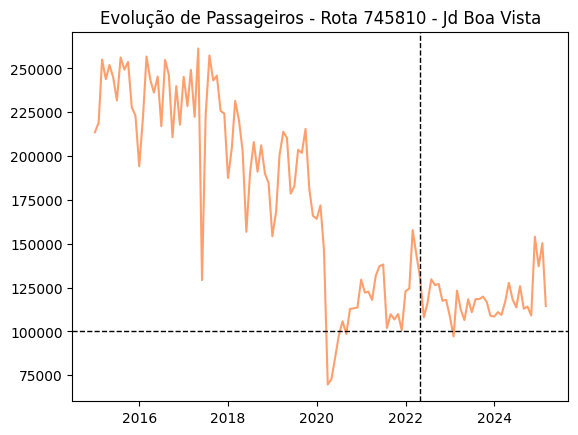

In [31]:
fig, ax = plt.subplots()
route = '745810'
ax.plot(df_pivot.index.to_pydatetime(), df_pivot[route],color=colors[-1])
ax.set_title('Evolução de Passageiros - Rota 745810 - Jd Boa Vista')
# Linhas adicionais para análise
ax.axhline(y=100_000, color='black', linestyle='--', linewidth=1)
ax.axvline(x=pd.to_datetime("2022-05"), color='black', linestyle='--', linewidth=1)
plt.savefig("Passageiros rota 745810 - Jd Boa Vista.png")
plt.show()


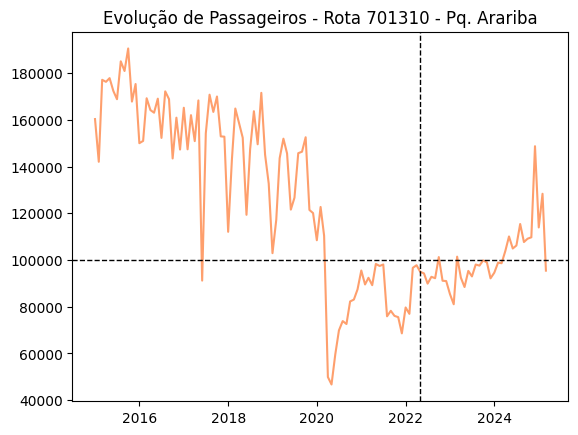

In [32]:
fig, ax = plt.subplots()
route = '701310'
ax.plot(df_pivot.index.to_pydatetime(), df_pivot[route],color=colors[-1])
ax.set_title('Evolução de Passageiros - Rota 701310 - Pq. Arariba')
# Linhas adicionais para análise
ax.axhline(y=100_000, color='black', linestyle='--', linewidth=1)
ax.axvline(x=pd.to_datetime("2022-05"), color='black', linestyle='--', linewidth=1)
plt.savefig("Passageiros rota 701310 - Pq. Arariba.png")
plt.show()


# Rotas que passam pela Raposo Tavares

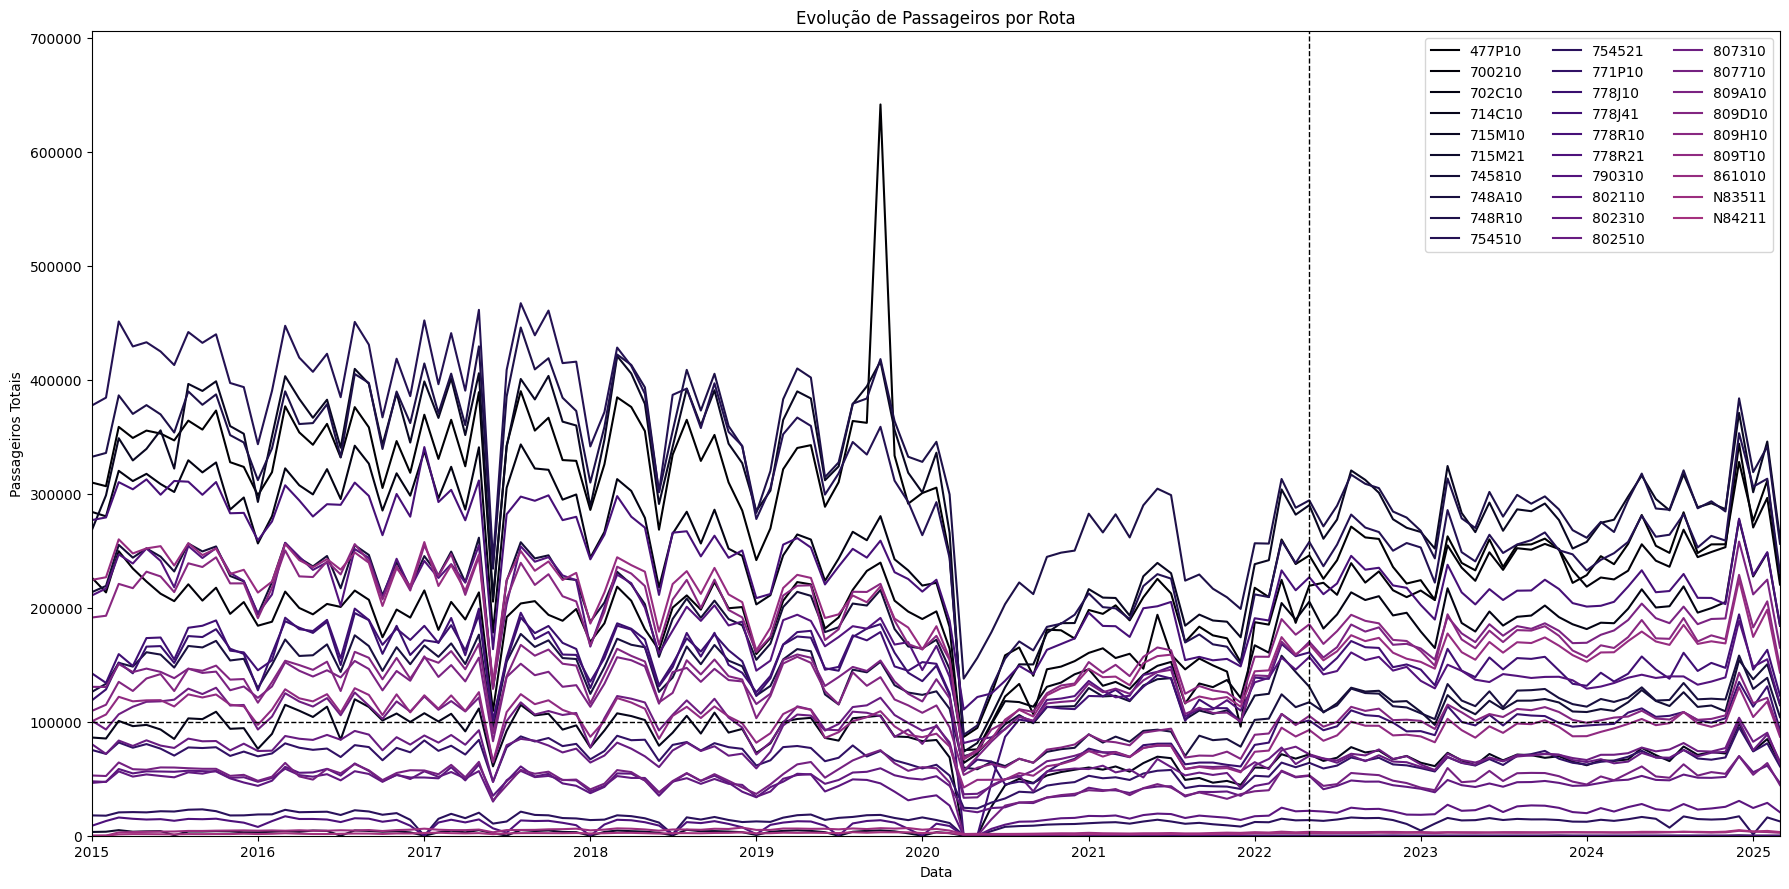

In [35]:
paradas_raposo_tavares=paradas[paradas.stop_name.str.lower().str.contains("raposo tavares")]
rotas_raposo_tavares=viagens.merge(paradas_raposo_tavares,on=['stop_id', 'stop_name', 'stop_desc', 'stop_lat', 'stop_lon',
       'data_referencia',],how='inner').route_id.drop_duplicates().to_list()

passageiros_filtrado=passageiros[passageiros.route_id.isin(rotas_raposo_tavares)]
passageiros_filtrado=passageiros_filtrado[passageiros_filtrado.data<="2025-03-31"]
df_pivot = passageiros_filtrado.pivot_table(index='data', columns='route_id', values='passageiros_total', aggfunc='sum')
df_pivot = df_pivot.fillna(0).sort_index()
df_pivot.index = df_pivot.index.to_timestamp()

fig, ax = plt.subplots(figsize=(18, 9))
colors = cm.magma(np.linspace(0, 0.8, 50))

# Aplica as cores, repetindo se houver mais que 20 rotas
for i, route in enumerate(df_pivot.columns):
    ax.plot(
        df_pivot.index.to_pydatetime(),
        df_pivot[route],
        label=route,
        color=colors[i]
    )

ax.set_xlim(df_pivot.index.min().to_pydatetime(), df_pivot.index.max().to_pydatetime())
ax.set_ylim(0, df_pivot.values.max() * 1.1)
ax.set_title('Evolução de Passageiros por Rota')
ax.set_xlabel('Data')
ax.set_ylabel('Passageiros Totais')

# Linhas adicionais para análise
ax.axhline(y=100_000, color='black', linestyle='--', linewidth=1)
ax.axvline(x=pd.to_datetime("2022-05"), color='black', linestyle='--', linewidth=1)

# Legenda em duas colunas para melhor ajuste
ax.legend(ncol=3)

plt.tight_layout()
plt.show()


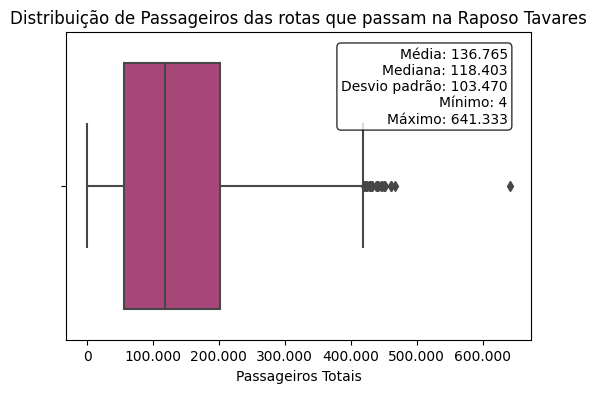

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# passageiros_agrupado=passageiros_filtrado.groupby("route_id")['passageiros_total'].median().reset_index()

# Cria o boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(x=passageiros_filtrado['passageiros_total'],palette='magma')
# Título e rótulos
plt.title('Distribuição de Passageiros das rotas que passam na Raposo Tavares')
plt.xlabel('Passageiros Totais')
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', '.')))


# Calcular estatísticas
media = passageiros_filtrado['passageiros_total'].mean()
mediana = passageiros_filtrado['passageiros_total'].median()
desvio = passageiros_filtrado['passageiros_total'].std()
minimo = passageiros_filtrado['passageiros_total'].min()
maximo = passageiros_filtrado['passageiros_total'].max()

# Mostrar estatísticas no gráfico
texto = (
    f"Média: {media:,.0f}\n"
    f"Mediana: {mediana:,.0f}\n"
    f"Desvio padrão: {desvio:,.0f}\n"
    f"Mínimo: {minimo:,.0f}\n"
    f"Máximo: {maximo:,.0f}"
).replace(",", ".")

plt.text(
    0.95, 0.95, texto,
    transform=plt.gca().transAxes,
    fontsize=10, va='top', ha='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)


plt.show()

# Rotas que passam pela Francisco Morato e Estrada do Campo Limpo

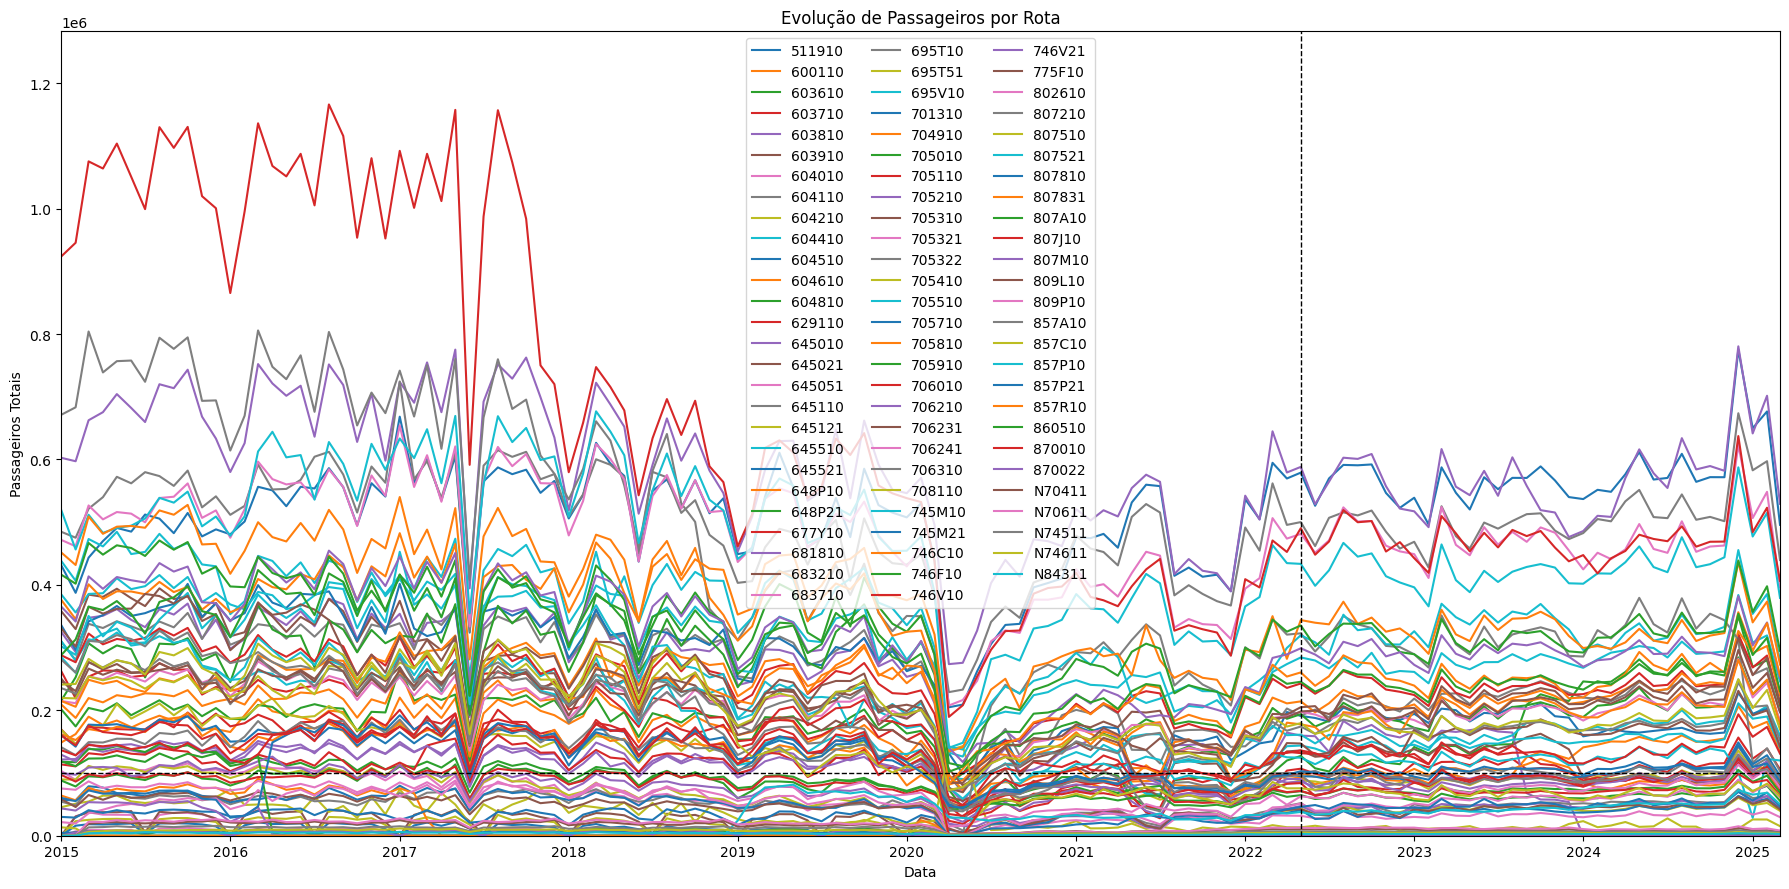

In [37]:
paradas_campo_limpo=paradas[paradas.stop_name.str.lower().str.contains("campo limpo")]
rotas_campo_limp=viagens.merge(paradas_campo_limpo,on=['stop_id', 'stop_name', 'stop_desc', 'stop_lat', 'stop_lon',
       'data_referencia',],how='inner').route_id.drop_duplicates().to_list()

passageiros_filtrado=passageiros[passageiros.route_id.isin(rotas_campo_limp)]
passageiros_filtrado=passageiros_filtrado[passageiros_filtrado.data<="2025-03-31"]
df_pivot = passageiros_filtrado.pivot_table(index='data', columns='route_id', values='passageiros_total', aggfunc='sum')
df_pivot = df_pivot.fillna(0).sort_index()
df_pivot.index = df_pivot.index.to_timestamp()

fig, ax = plt.subplots(figsize=(18, 9))

# Aplica as cores, repetindo se houver mais que 20 rotas
for i, route in enumerate(df_pivot.columns):
    ax.plot(
        df_pivot.index.to_pydatetime(),
        df_pivot[route],
        label=route,
    )

ax.set_xlim(df_pivot.index.min().to_pydatetime(), df_pivot.index.max().to_pydatetime())
ax.set_ylim(0, df_pivot.values.max() * 1.1)
ax.set_title('Evolução de Passageiros por Rota')
ax.set_xlabel('Data')
ax.set_ylabel('Passageiros Totais')

# Linhas adicionais para análise
ax.axhline(y=100_000, color='black', linestyle='--', linewidth=1)
ax.axvline(x=pd.to_datetime("2022-05"), color='black', linestyle='--', linewidth=1)

# Legenda em duas colunas para melhor ajuste
ax.legend(ncol=3)

plt.tight_layout()
plt.show()


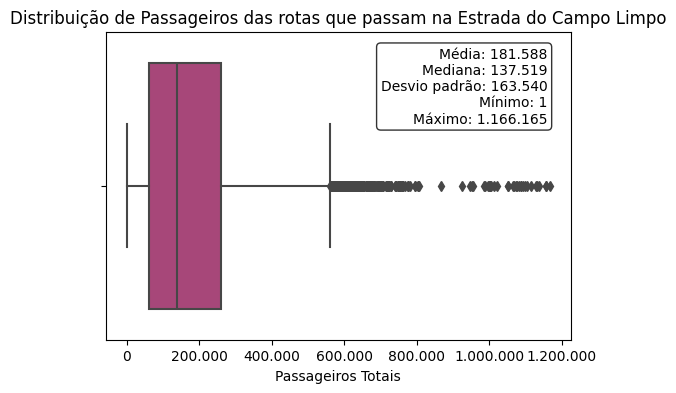

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# passageiros_agrupado=passageiros_filtrado.groupby("route_id")['passageiros_total'].median().reset_index()

# Cria o boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(x=passageiros_filtrado['passageiros_total'],palette='magma')
# Título e rótulos
plt.title('Distribuição de Passageiros das rotas que passam na Estrada do Campo Limpo')
plt.xlabel('Passageiros Totais')
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', '.')))


# Calcular estatísticas
media = passageiros_filtrado['passageiros_total'].mean()
mediana = passageiros_filtrado['passageiros_total'].median()
desvio = passageiros_filtrado['passageiros_total'].std()
minimo = passageiros_filtrado['passageiros_total'].min()
maximo = passageiros_filtrado['passageiros_total'].max()

# Mostrar estatísticas no gráfico
texto = (
    f"Média: {media:,.0f}\n"
    f"Mediana: {mediana:,.0f}\n"
    f"Desvio padrão: {desvio:,.0f}\n"
    f"Mínimo: {minimo:,.0f}\n"
    f"Máximo: {maximo:,.0f}"
).replace(",", ".")

plt.text(
    0.95, 0.95, texto,
    transform=plt.gca().transAxes,
    fontsize=10, va='top', ha='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)


plt.show()

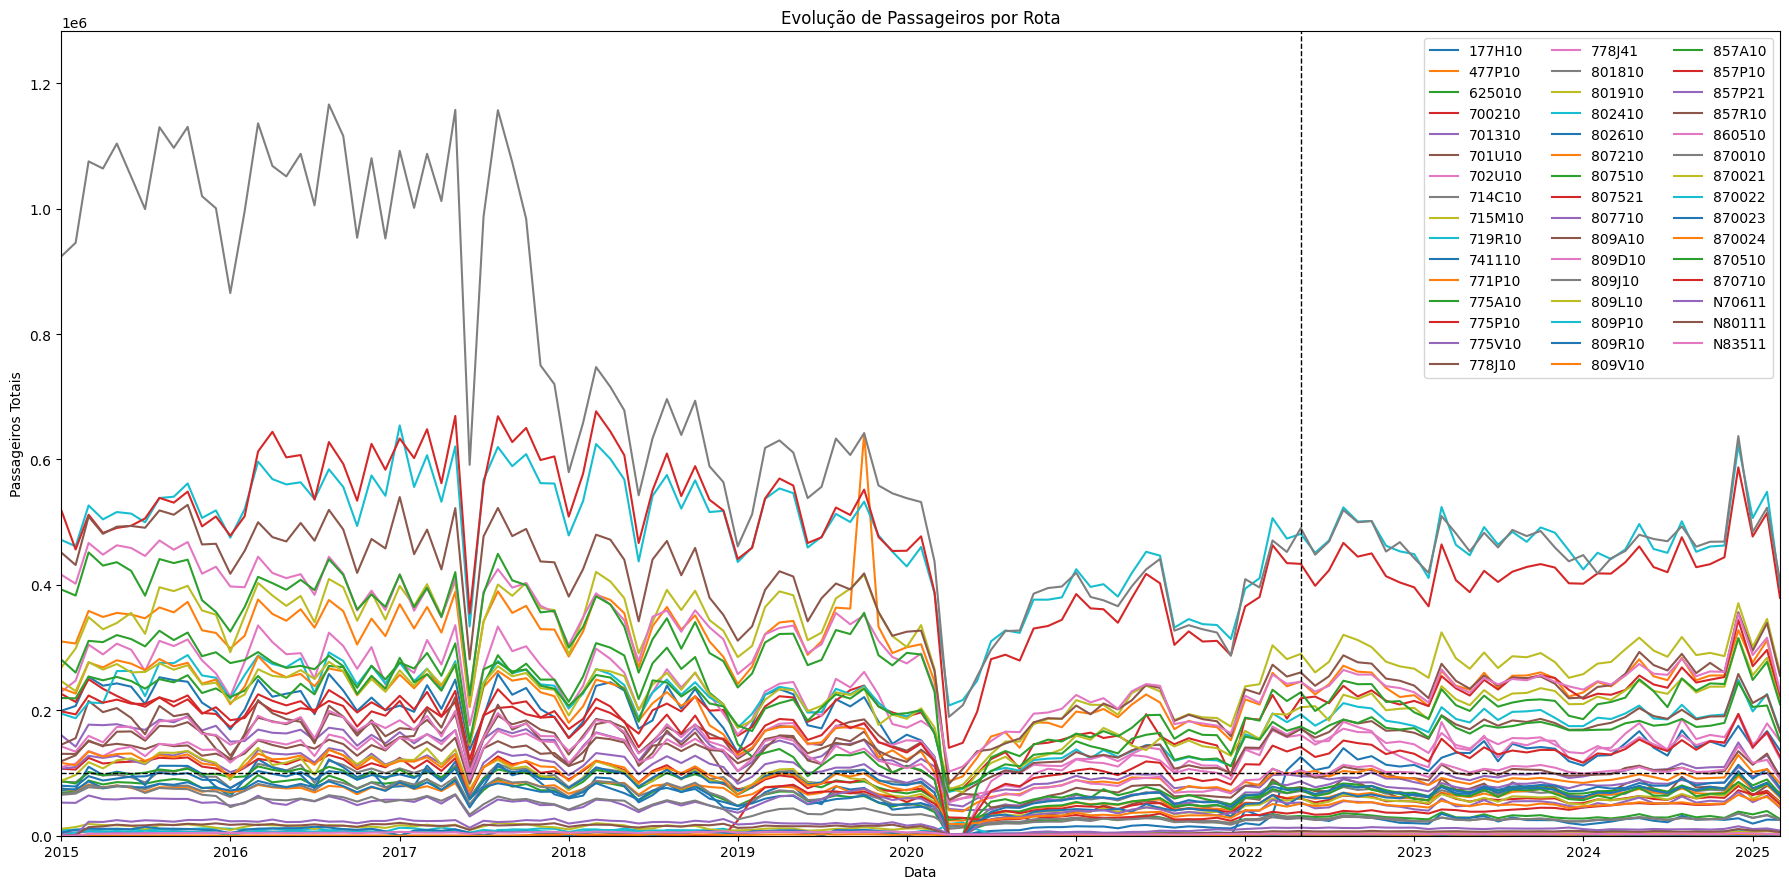

In [39]:
paradas_campo_limpo=paradas[paradas.stop_name.str.lower().str.contains("francisco morato")]
rotas_campo_limp=viagens.merge(paradas_campo_limpo,on=['stop_id', 'stop_name', 'stop_desc', 'stop_lat', 'stop_lon',
       'data_referencia',],how='inner').route_id.drop_duplicates().to_list()

passageiros_filtrado=passageiros[passageiros.route_id.isin(rotas_campo_limp)]
passageiros_filtrado=passageiros_filtrado[passageiros_filtrado.data<="2025-03-31"]
df_pivot = passageiros_filtrado.pivot_table(index='data', columns='route_id', values='passageiros_total', aggfunc='sum')
df_pivot = df_pivot.fillna(0).sort_index()
df_pivot.index = df_pivot.index.to_timestamp()

fig, ax = plt.subplots(figsize=(18, 9))

# Aplica as cores, repetindo se houver mais que 20 rotas
for i, route in enumerate(df_pivot.columns):
    ax.plot(
        df_pivot.index.to_pydatetime(),
        df_pivot[route],
        label=route,
    )

ax.set_xlim(df_pivot.index.min().to_pydatetime(), df_pivot.index.max().to_pydatetime())
ax.set_ylim(0, df_pivot.values.max() * 1.1)
ax.set_title('Evolução de Passageiros por Rota')
ax.set_xlabel('Data')
ax.set_ylabel('Passageiros Totais')

# Linhas adicionais para análise
ax.axhline(y=100_000, color='black', linestyle='--', linewidth=1)
ax.axvline(x=pd.to_datetime("2022-05"), color='black', linestyle='--', linewidth=1)

# Legenda em duas colunas para melhor ajuste
ax.legend(ncol=3)

plt.tight_layout()
plt.show()


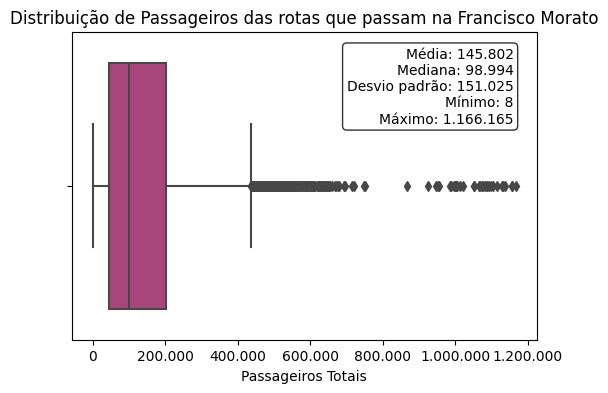

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# passageiros_agrupado=passageiros_filtrado.groupby("route_id")['passageiros_total'].median().reset_index()

# Cria o boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(x=passageiros_filtrado['passageiros_total'],palette='magma')
# Título e rótulos
plt.title('Distribuição de Passageiros das rotas que passam na Francisco Morato')
plt.xlabel('Passageiros Totais')
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', '.')))


# Calcular estatísticas
media = passageiros_filtrado['passageiros_total'].mean()
mediana = passageiros_filtrado['passageiros_total'].median()
desvio = passageiros_filtrado['passageiros_total'].std()
minimo = passageiros_filtrado['passageiros_total'].min()
maximo = passageiros_filtrado['passageiros_total'].max()

# Mostrar estatísticas no gráfico
texto = (
    f"Média: {media:,.0f}\n"
    f"Mediana: {mediana:,.0f}\n"
    f"Desvio padrão: {desvio:,.0f}\n"
    f"Mínimo: {minimo:,.0f}\n"
    f"Máximo: {maximo:,.0f}"
).replace(",", ".")

plt.text(
    0.95, 0.95, texto,
    transform=plt.gca().transAxes,
    fontsize=10, va='top', ha='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)


plt.show()